In [1]:
# %% import package to use
import datatable
import pandas as pd
from IPython.display import display
import numpy as np
import os
from sklearn.metrics import r2_score
import xgboost as xgb
pd.set_option('display.max_columns', None)

df_results_rf = pd.read_csv('./grid_search/results_rf_reg.csv', index_col='Unnamed: 0')
df_results_linear = pd.read_csv('./grid_search/results_linear_reg.csv', index_col='Unnamed: 0')
df_results_elastic = pd.read_csv('./grid_search/results_elastic_reg.csv', index_col='Unnamed: 0')

rf_best_param = df_results_rf.loc[df_results_rf['rank_test_score'] == 1].iloc[-1]
linear_best_param = df_results_linear.loc[df_results_linear['rank_test_score'] == 1].iloc[-1]
elastic_best_param = df_results_elastic.loc[df_results_elastic['rank_test_score'] == 1].iloc[-1]


import pickle
with open('./grid_search/results_xg_reg.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)
xg_best_param = df_results_xg[df_results_xg['mean_score'] == df_results_xg['mean_score'].max()][['max_depth', 'learning_rate', 'lambda', 'gamma', 'scores']].reset_index(drop=True)



In [2]:
import pickle
with open('./grid_search/results_xg_reg.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['mean_score'] == df_results_xg['mean_score'].max()][['max_depth', 'learning_rate', 'lambda', 'gamma', 'scores']].reset_index(drop=True)

with open('./grid_search/results_10_rf_reg.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

#### Random Forest
df_results_rf = pd.DataFrame()
for condition in results:
    df_results_rf = pd.concat((df_results_rf, pd.DataFrame(results[condition])), axis=0)
    
rf_best_param = df_results_rf[df_results_rf['mean_score'] == df_results_rf['mean_score'].max()][['n_estimators', 'criterion', 'min_samples_split', 'max_features', 'scores']].reset_index(drop=True)


#### Linear Regression
with open('./grid_search/results_10_linear_reg.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results_linear = pd.DataFrame()
for condition in results:
    df_results_linear = pd.concat((df_results_linear, pd.DataFrame(results[condition])), axis=0)
    
linear_best_param = df_results_linear[df_results_linear['mean_score'] == df_results_linear['mean_score'].max()][['normalize', 'scores']].reset_index(drop=True)


#### ElasticNet
with open('./grid_search/results_10_elastic_reg.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results_elastic = pd.DataFrame()
for condition in results:
    df_results_elastic = pd.concat((df_results_elastic, pd.DataFrame(results[condition])), axis=0)
    
elastic_best_param = df_results_elastic[df_results_elastic['mean_score'] == df_results_elastic['mean_score'].max()][['alpha', 'l1_ratio', 'selection', 'scores']].reset_index(drop=True)

In [3]:
# %% Load dataset
DATA_PATH = "/home/lkh256/Studio/VO2max_Prediction/Data"
df_init = datatable.fread(os.path.join(DATA_PATH, 'general_eq.csv'), encoding='utf-8-sig', na_strings=['', 'NA']).to_pandas()
df_init['SM_DATE'] = df_init['SM_DATE'].astype('datetime64')

print(df_init.isnull().sum())

df_init = df_init.fillna(df_init.median())

print("Number of samples = {}".format(len(df_init)))

# %% Check missings
print("Check their is any missing variables in dataset: \n", df_init.isnull().sum())

# %% Sort visit number and select rows to analysis
df_init['visit_num'] = df_init.groupby(['HPCID'])['SM_DATE'].apply(pd.Series.rank)
df_selected = df_init[df_init['visit_num'] == 1].reset_index(drop=True)
print("Number of eq case = {}".format(len(df_selected)))


feature_mask = ['AGE', 'sex', 'BMI', 'rest_HR', 'MVPA']

# %%
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_selected,  
                                       random_state=1005, 
                                       stratify=df_selected['sex'], 
                                       test_size=0.2)

print("Train set size = {}".format(len(train_set)))
print("Test set size = {}".format(len(test_set)))

X_train = train_set[feature_mask].values
y_train = train_set['VO2max'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['VO2max'].values
dtest = xgb.DMatrix(X_test, label=y_test)


SM_DATE                 0
HPCID                   0
sex                     0
AGE                     0
percentage_fat          0
Height                  0
Weight                  0
BMI                     0
MVPA                    0
rest_HR                 0
Smoke                   0
CRF                     0
비만도                     0
Muscle_mass             0
복부지방율                   0
부종검사                    0
Muscle_mass(RA)         0
Muscle_mass(LA)         0
Muscle_mass(BODY)       0
Muscle_mass(RL)         0
Muscle_mass(LL)         0
체지방량                    0
체수분량                    0
제지방량                    0
CRP                  1099
CHOLESTEROL           203
TG                    203
max_heart_rate          0
BMI_cal                 0
ASMI                    0
VO2max                  0
death                   0
delta_time              0
Diabetes                0
Hypertension            0
HTN_med                 0
Hyperlipidemia          0
Hepatatis               0
ALC         

## Random Forest

In [4]:
rf_best_param.head(1)

,n_estimators,criterion,min_samples_split,max_features,scores
0,900,mse,4,log2,0.413053


In [5]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(criterion='mse', max_features='log2', min_samples_split=4, n_estimators=900, n_jobs=-1, random_state=1004)

feature_mask = ['AGE', 'sex', 'BMI', 'rest_HR', 'MVPA']

rf_reg.fit(train_set[feature_mask], train_set['VO2max'])

print("Train R^2 Score : ", r2_score(y_pred=rf_reg.predict(train_set[feature_mask]), y_true=train_set['VO2max']))
print("Test R^2 Score", r2_score(y_pred=rf_reg.predict(test_set[feature_mask]), y_true=test_set['VO2max']))



Train R^2 Score :  0.8142007817342336
Test R^2 Score 0.39985354248616434


## Linear Regression

In [6]:
linear_best_param.head(1)

,normalize,scores
0,False,0.446038


In [7]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression(normalize=False)

feature_mask = ['AGE', 'sex', 'BMI', 'rest_HR', 'MVPA']

linear_reg.fit(train_set[feature_mask], train_set['VO2max'])

print("Train R^2 Score : ", r2_score(y_pred=linear_reg.predict(train_set[feature_mask]), y_true=train_set['VO2max']))
print("Test R^2 Score", r2_score(y_pred=linear_reg.predict(test_set[feature_mask]), y_true=test_set['VO2max']))


Train R^2 Score :  0.463176910680567
Test R^2 Score 0.4398375351336786


## Elastic Network

In [8]:
elastic_best_param.head(1)

,alpha,l1_ratio,selection,scores
0,0.1,1,cyclic,0.422904


In [9]:
from sklearn.linear_model import ElasticNet

elastic_reg = ElasticNet(alpha=0.1, l1_ratio=1, normalize=False, selection='cyclic')

elastic_reg.fit(train_set[feature_mask], train_set['VO2max'])

print("Train R^2 Score : ", r2_score(y_pred=elastic_reg.predict(train_set[feature_mask]), y_true=train_set['VO2max']))
print("Test R^2 Score", r2_score(y_pred=elastic_reg.predict(test_set[feature_mask]), y_true=test_set['VO2max']))

Train R^2 Score :  0.45448303678186086
Test R^2 Score 0.4348263757757269


## XGBoost

In [10]:
import xgboost as xgb

params = {'objective': 'reg:squarederror',
                            'eval_metric': 'rmse',
                            'tree_method': 'gpu_hist', 
                            'gpu_id': '0',
                            'learning_rate': 0.001, 
                            'max_depth': 3,
                            'lambda': 3,
                            'gamma': 0.1}

model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train R^2 Score", r2_score(y_train, model_xgb.predict(dtrain)))
print("Test R^2 Score", r2_score(y_test, model_xgb.predict(dtest)))

Train R^2 Score 0.5004588590568088
Test R^2 Score 0.4498119865841803


# Visualization

In [18]:
rf_best_param

,n_estimators,criterion,min_samples_split,max_features,scores
0,900,mse,4,log2,0.413053
1,900,mse,4,log2,0.371192
2,900,mse,4,log2,0.387199
3,900,mse,4,log2,0.376486
4,900,mse,4,log2,0.387893
...,...,...,...,...,...
95,900,mse,4,log2,0.408526
96,900,mse,4,log2,0.361223
97,900,mse,4,log2,0.387791
98,900,mse,4,log2,0.428286


In [22]:
best_results_xg = xg_best_param[['scores']]
best_results_xg['model'] = 'XG Boost'

best_results_rf = rf_best_param[['scores']]
best_results_rf['model'] = 'Random Forest'

best_results_linear = linear_best_param[['scores']]
best_results_linear['model'] = 'Linear Regression'

best_results_elastic = elastic_best_param[['scores']]
best_results_elastic['model'] = 'ElasticNet'

best_results = pd.concat((best_results_rf, best_results_linear, best_results_elastic, best_results_xg), axis=0)

<ipython-input-22-8c17cf91abd1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_results_xg['model'] = 'XG Boost'
<ipython-input-22-8c17cf91abd1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_results_rf['model'] = 'Random Forest'
<ipython-input-22-8c17cf91abd1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

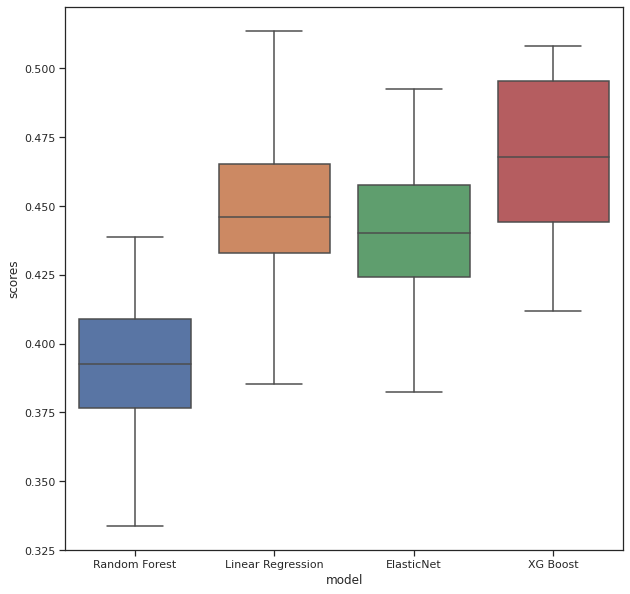

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.boxplot(x='model', y='scores', data=best_results)
plt.show()


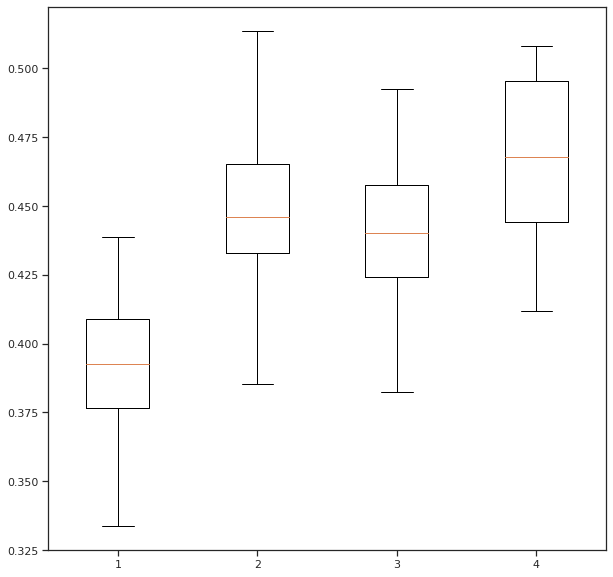

In [25]:
data = [best_results.loc[best_results['model'] == 'Random Forest', 'scores'], 
best_results.loc[best_results['model'] == 'Linear Regression', 'scores'], 
best_results.loc[best_results['model'] == 'ElasticNet', 'scores'],
best_results.loc[best_results['model'] == 'XG Boost', 'scores']]
plt.figure(figsize=(10, 10))
plt.boxplot(data)
plt.show()

### One-way ANOVA

In [28]:
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.multitest import multipletests

print(anova_oneway(data=best_results['scores'], groups=best_results['model'], use_var='unequal', welch_correction=True))
print(multipletests)

statistic = 120.40446630570761
pvalue = 2.0008749431907413e-20
df = (3.0, 41.21444657265602)
df_num = 3.0
df_denom = 41.21444657265602
nobs_t = 310.0
n_groups = 4
means = [0.44060291 0.44928125 0.39271534 0.46785644]
nobs = [100. 100. 100.  10.]
vars_ = [0.00046153 0.00056643 0.00051142 0.00105292]
use_var = unequal
welch_correction = True
tuple = (120.40446630570761, 2.0008749431907413e-20)
<function multipletests at 0x7f6cbc443940>


### Bonferroni Correction

In [29]:
from statsmodels.sandbox.stats.multicomp import MultiComparison
import scipy.stats
comp = MultiComparison(best_results['scores'], best_results['model'])
test_result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
test_result[0]

group1,group2,stat,pval,pval_corr,reject
ElasticNet,Linear Regression,-2.7068,0.0074,0.0443,True
ElasticNet,Random Forest,15.3525,0.0,0.0,True
ElasticNet,XG Boost,-3.6358,0.0004,0.0026,True
Linear Regression,Random Forest,17.2297,0.0,0.0,True
Linear Regression,XG Boost,-2.2733,0.025,0.1499,False
Random Forest,XG Boost,-9.6036,0.0,0.0,True


# Testset Metric

In [30]:
r2_rf_test = r2_score(y_pred=rf_reg.predict(test_set[feature_mask]), y_true=test_set['VO2max'])
r2_linear_test = r2_score(y_pred=linear_reg.predict(test_set[feature_mask]), y_true=test_set['VO2max'])
r2_elastic_test = r2_score(y_pred=elastic_reg.predict(test_set[feature_mask]), y_true=test_set['VO2max'])
r2_xg_test = r2_score(y_pred=model_xgb.predict(dtest), y_true=test_set['VO2max'])
print(r2_rf_test)
print(r2_linear_test)
print(r2_elastic_test)
print(r2_xg_test)

0.39985354248616434
0.4398375351336786
0.4348263757757269
0.4498119865841803


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Random Forest v.s. ElasticNet: t-test independent samples with Bonferroni correction, P_val=8.913e-35 stat=-1.535e+01
ElasticNet v.s. Linear Regression: t-test independent samples with Bonferroni correction, P_val=4.433e-02 stat=-2.707e+00
Linear Regression v.s. XG Boost: t-test independent samples with Bonferroni correction, P_val=1.499e-01 stat=-2.273e+00
Random Forest v.s. Linear Regression: t-test independent samples with Bonferroni correction, P_val=1.806e-40 stat=-1.723e+01
ElasticNet v.s. XG Boost: t-test independent samples with Bonferroni correction, P_val=2.558e-03 stat=-3.636e+00
Random Forest v.s. XG Boost: t-test independent samples with Bonferroni correction, P_val=2.232e-15 stat=-9.604e+00


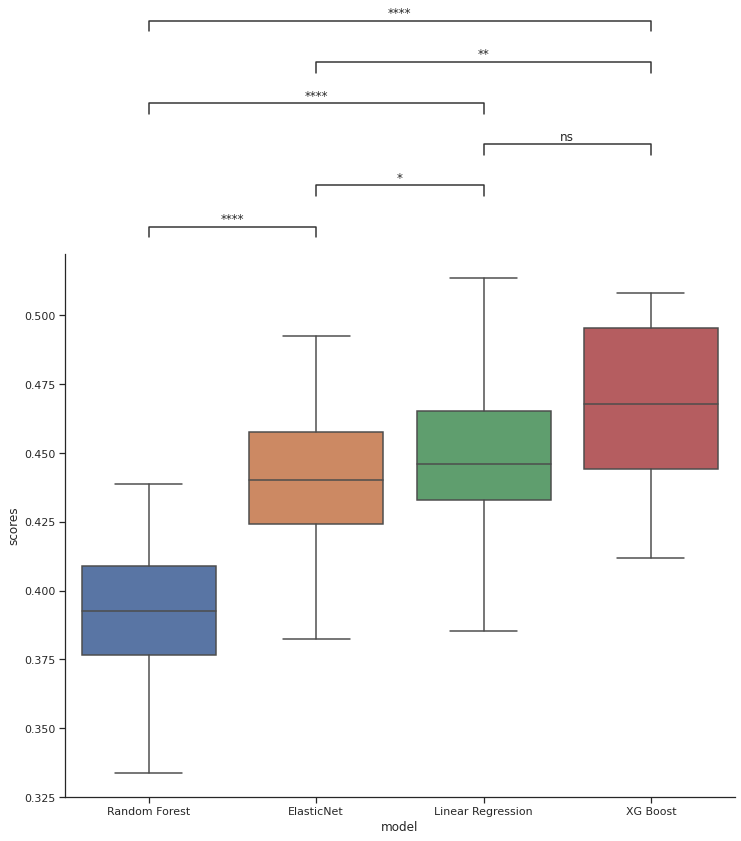

In [33]:
from statannot import add_stat_annotation
from itertools import combinations
import seaborn as sns
sns.set(style='ticks')

list_model = ["Random Forest", "ElasticNet", "Linear Regression", 'XG Boost']

oder = combinations(list_model, 2)
plt.figure(figsize=(12,10))
x = 'model'
y = 'scores'
order = list(list_model)
ax = sns.boxplot(data=best_results, x=x, y=y, order=order)
ax, test_results = add_stat_annotation(ax, data=best_results, x=x, y=y, order=list_model,
                                   box_pairs=oder,
                                   test='t-test_ind', text_format='star', loc='outside', verbose=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.despine()